In [1]:
import cv2
import torchxrayvision as xrv
import skimage, torch, torchvision
import matplotlib.pyplot as plt

/home/adarsha/anaconda3/envs/clinicalai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


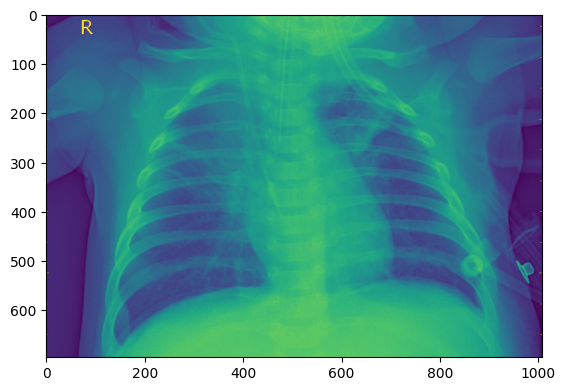

In [12]:
img_path = "/home/adarsha/Documents/Projects/explainableAI/test/PNEUMONIA/person8_virus_27.jpeg"
img = skimage.io.imread(img_path)
plt.imshow(img)

img = xrv.datasets.normalize(img, 255)  


if img.ndim == 3:  # convert to grayscale
    img = img.mean(2)

img = img[None, ...]  
transform = torchvision.transforms.Compose([
    xrv.datasets.XRayCenterCrop(),
    xrv.datasets.XRayResizer(224)
])
img = transform(img)
img = torch.from_numpy(img)
# img_tensor = torch.from_numpy(img).unsqueeze(0)  


In [13]:
# Load model and process image
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.eval()

XRV-DenseNet121-densenet121-res224-all

In [14]:
# Print results
outputs = model(img[None,...]) # or model.features(img[None,...])
dict(zip(model.pathologies,outputs[0].detach().numpy()))


{'Atelectasis': np.float32(0.073938705),
 'Consolidation': np.float32(0.30525684),
 'Infiltration': np.float32(0.52344847),
 'Pneumothorax': np.float32(0.50107473),
 'Edema': np.float32(0.018877128),
 'Emphysema': np.float32(0.13769925),
 'Fibrosis': np.float32(0.08419923),
 'Effusion': np.float32(0.18188517),
 'Pneumonia': np.float32(0.041293103),
 'Pleural_Thickening': np.float32(0.09147302),
 'Cardiomegaly': np.float32(0.33668557),
 'Nodule': np.float32(0.15369031),
 'Mass': np.float32(0.18807676),
 'Hernia': np.float32(0.00041259505),
 'Lung Lesion': np.float32(0.0026615502),
 'Fracture': np.float32(0.14757738),
 'Lung Opacity': np.float32(0.31718445),
 'Enlarged Cardiomediastinum': np.float32(0.5466526)}

In [15]:
# {'Atelectasis': np.float32(0.073938705),
#  'Consolidation': np.float32(0.30525684),
#  'Infiltration': np.float32(0.52344847),
#  'Pneumothorax': np.float32(0.50107473),
#  'Edema': np.float32(0.018877128),
#  'Emphysema': np.float32(0.13769925),
#  'Fibrosis': np.float32(0.08419923),
#  'Effusion': np.float32(0.18188517),
#  'Pneumonia': np.float32(0.041293103),
#  'Pleural_Thickening': np.float32(0.09147302),
#  'Cardiomegaly': np.float32(0.33668557),
#  'Nodule': np.float32(0.15369031),
#  'Mass': np.float32(0.18807676),
#  'Hernia': np.float32(0.00041259505),
#  'Lung Lesion': np.float32(0.0026615502),
#  'Fracture': np.float32(0.14757738),
#  'Lung Opacity': np.float32(0.31718445),
#  'Enlarged Cardiomediastinum': np.float32(0.5466526)}

In [16]:
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [17]:
model.eval()

XRV-DenseNet121-densenet121-res224-all

In [18]:
model.pathologies.index("Pneumonia")


8

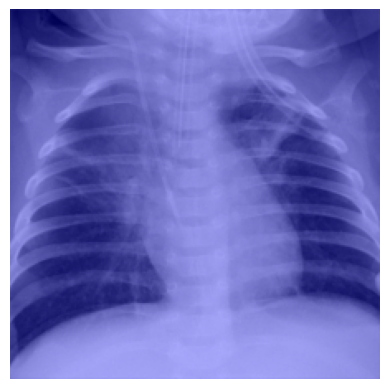

Predicted probabilities for all pathologies:

 0. Atelectasis              : 51.8476
 1. Consolidation            : 57.5727
 2. Infiltration             : 62.7954
 3. Pneumothorax             : 62.2712
 4. Edema                    : 50.4719
 5. Emphysema                : 53.4370
 6. Fibrosis                 : 52.1037
 7. Effusion                 : 54.5346
 8. Pneumonia                : 51.0322
 9. Pleural_Thickening       : 52.2852
10. Cardiomegaly             : 58.3385
11. Nodule                   : 53.8347
12. Mass                     : 54.6881
13. Hernia                   : 50.0103
14. Lung Lesion              : 50.0665
15. Fracture                 : 53.6828
16. Lung Opacity             : 57.8638
17. Enlarged Cardiomediastinum: 63.3359


In [19]:


img_tensor = img.unsqueeze(0)

target_class = model.pathologies.index("Pneumonia")

target_layer = model.features[-1]  # last conv layer
cam = GradCAM(model=model, target_layers=[target_layer])

grayscale_cam = cam(input_tensor=img_tensor, targets=[ClassifierOutputTarget(target_class)])
grayscale_cam = grayscale_cam[0, :]  # shape: [224, 224]

# img[0] has shape (224, 224). Stack it three times to create a 3-channel image.
rgb_img = np.stack([img[0], img[0], img[0]], axis=-1)

# Normalize the image to a float range [0, 1]
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(visualization)
plt.axis('off')
plt.show()

#Inference on all classes
with torch.no_grad():
    output = model(img_tensor)[0]  

probabilities = torch.sigmoid(output)

print("Predicted probabilities for all pathologies:\n")
for idx, (pathology, prob) in enumerate(zip(model.pathologies, probabilities)):
    print(f"{idx:2d}. {pathology:25s}: {prob.item() * 100:.4f}")




In [ ]:
def map_heatmap_to_cues(heatmap, threshold=0.5):
    """
    Map Grad-CAM heatmap to ecologically valid cues.
    threshold: relative intensity threshold (0-1) for activation.
    """
    cues = []
    h, w = heatmap.shape
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Threshold binary mask
    mask = heatmap_norm > threshold

    # Define regions (you can refine these)
    upper = mask[:h//2, :]
    lower = mask[h//2:, :]
    left = mask[:, :w//2]
    right = mask[:, w//2:]

    # Check region coverage
    if upper.sum() / mask.sum() > 0.7:
        cues.append("Diffuse lung opacity")
    else:
        if lower[:, :w//2].sum() > 0:  # lower left
            cues.append("Lobar opacity - left lower lung")
        if lower[:, w//2:].sum() > 0:  # lower right
            cues.append("Lobar opacity - right lower lung")
        if upper[:, :w//2].sum() > 0:  # upper left
            cues.append("Interstitial markings - left upper lung")
        if upper[:, w//2:].sum() > 0:  # upper right
            cues.append("Interstitial markings - right upper lung")

    return cues
